In [12]:
using AbstractFFTs
using FFTW
using Plots

function meshgrid(x_,y_)
    lenx = length(y_)
    leny = length(x_)
    x = x_'.* ones(lenx)
    y = ones(leny)'.* y_
    return x,y
end

mutable struct Fluid
    nx::Int
    ny::Int
    nk::Int
    Re::Int
    ReI::Float64
    dt::Float64
    pad::Float64
    time::Float64
    it::Int
    fftw_num_threads
    x 
    dx
    y 
    dy
    kx
    ky
    fk
    k2
    k2I
    mx
    mk
    my
    padder 
    u
    v
    w
    f
    uh 
    vh 
    wh0
    wh 
    fh 
    psih 
    dwhdt

end

function construct(grid_size)
    # input data
    nx = grid_size
    ny = grid_size
    nk = ny÷2+1
    Re = 100
    ReI = 0
    if Re != 0
        ReI = 1/Re
    end
    dt = 0.0001
    pad = 3/2
    time = 0
    it = 0

    fftw_num_threads = 8

    # we assume 2pi periodic domain in each dimensions
    x = range(0, 2*pi, nx+1)[1:end-1]
    dx = x[2]-x[1]
    y = range(0, 2*pi, ny+1)[1:end-1]
    dy = y[2]-y[1]

    kx = fftfreq(nx) .* nx
    ky = fftfreq(ny) .* ny

    kxs, kys = meshgrid(kx[1:nk], ky)

    k2 = kxs.^2 .+ kys.^2
    k2I = zeros(nx, nk)
    fk = k2 .!= 0.0
    k2I[fk] = 1.0 ./ k2[fk]

    mx = convert(Int, floor(pad*nx))
    mk = convert(Int, floor(pad*nk))
    my = convert(Int, floor(pad*ny))

    padder = convert(Array{Bool}, ones(Int, mx))
    padder[convert(Int, nx/2+1):convert(Int, nx*(pad-0.5))] .= false

    u = zeros(nx, ny)
    v = zeros(nx, ny)
    w = zeros(nx, ny)
    f = zeros(nx, ny)

    uh  = zeros(Complex{Float64}, nx, nk)
    vh  = zeros(Complex{Float64}, nx, nk)
    wh0 = zeros(Complex{Float64}, nx, nk)
    wh  = zeros(Complex{Float64}, nx, nk)
    fh  = zeros(Complex{Float64}, nx, nk)
    psih = zeros(Complex{Float64}, nx, nk)
    dwhdt = zeros(Complex{Float64}, nx, nk)
    print(size(wh))

    """println(nx, ny, nk, Re, ReI,dt,pad, """
    """time, it, fftw_num_threads, """
    """x, dx, y, dy, kx, ky, fk, k2, k2I,"""
    """mx, mk, my, padder, u, v, w, """
    """f, uh, vh, wh0, wh, fh, psih, dwhdt)"""

    flow = Fluid(nx, ny, nk, Re, ReI,dt,pad, 
                time, it, fftw_num_threads, 
                x, dx, y, dy, kx, ky, fk, k2, k2I,
                mx, mk, my, padder, u, v, w, 
                f, uh, vh, wh0, wh, fh, psih, dwhdt)
    return flow
end



construct (generic function with 1 method)

In [13]:

function get_u(self::Fluid)
    self.uh = 1im.*self.ky.*self.psih
    self.u = transpose(irfft(copy(transpose(self.uh)), self.my))
end

function get_v(self::Fluid)
    self.vh = -1im.*self.kx[1:self.nk]' .* self.psih
    self.v = transpose(irfft(copy(transpose(self.vh)), self.my))
end

function cfl_limit(self::Fluid)
    get_u(self)
    get_v(self)
    Dc = maximum(π .* ((1.0 .+ abs.(self.u)) ./ self.dx +
                    (1.0 .+ abs.(self.v)) ./ self.dy))
    Dmu = π^2*(self.dx^(-2) + self.dy^(-2))
    return sqrt(3.0) / (Dc + Dmu)
end

function get_psih(self::Fluid)
    self.psih =  self.wh .* self.k2I
end

function add_convection(self::Fluid)
    # padded arrays
    j1f_padded = zeros(Complex{Float64}, self.mx, self.mk)
    j2f_padded = zeros(Complex{Float64}, self.mx, self.mk)
    j3f_padded = zeros(Complex{Float64}, self.mx, self.mk)
    j4f_padded = zeros(Complex{Float64}, self.mx, self.mk)
    #print(size(1.0im .* kx[1:nk].*psih'))
    j1f_padded[self.padder, 1:self.nk] = 1.0im .* self.kx[1:self.nk]' .* self.psih
    j2f_padded[self.padder, 1:self.nk] = 1.0im .* self.kx .* self.wh
    j3f_padded[self.padder, 1:self.nk] = 1.0im .* self.ky .* self.psih
    j4f_padded[self.padder, 1:self.nk] = 1.0im .* self.kx[1:self.nk]' .* self.wh


    # ifft
    j1 = transpose(irfft(copy(transpose(j1f_padded)), self.my))
    j2 = transpose(irfft(copy(transpose(j2f_padded)), self.my))
    j3 = transpose(irfft(copy(transpose(j3f_padded)), self.my))
    j4 = transpose(irfft(copy(transpose(j4f_padded)), self.my))

    jacp = j1 .* j2 .- j3 .* j4


    jacpf = transpose(rfft(transpose(jacp)))

    dwhdt = jacpf[self.padder, 1:self.nk] .* self.pad^(2)  # this term is the result of padding
    return dwhdt
end

function add_diffusion(self::Fluid, dwhdt)
    new_dwhdt = dwhdt .- self.ReI .* self.k2 .* self.wh
    return new_dwhdt
end


function update(self::Fluid)
    # iniitalise field
    self.wh0 = self.wh

    for k=3:-1:1
        # invert Poisson equation for the stream function (changes to k-space)
        get_psih(self)
        
        # get convective forces (resets dwhdt)
        dwhdt = add_convection(self)
        
        # add diffusion
        dwhdt = add_diffusion(self, dwhdt)
        
        # step in time
        self.wh = self.wh0 + (self.dt/k) .* dwhdt
    end
    self.time += self.dt
    #self.dt = cfl_limit(self)
    self.it += 1
end

update (generic function with 1 method)

(8, 5)-10.0:2.857142857142857:10.0

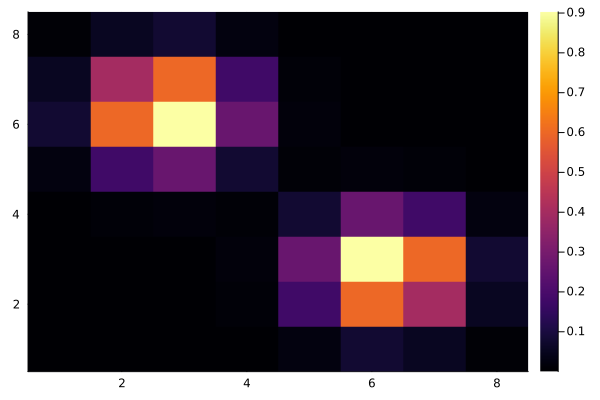

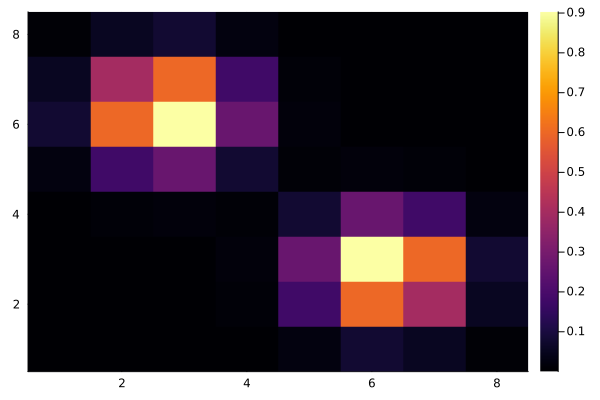

In [3]:
max_iter = 10000
flow = construct(8)

lin = range(-10,10,8)
print(lin)

x,y = meshgrid(lin, lin)
#print(x)
gaussian(A, alpha, x1, x2, y1, y2) = A*(exp.(-alpha.*((x .- x1).^2 + (y .- y1).^2)) 
                                        + exp.(-alpha.*((x .- x2).^2 + (y .- y2).^2)))

w = gaussian(1, 0.1, 5, -5, -5, 5)#
#w = 10.0 .*(rand(flow.nx, flow.ny).-0.5)
#print(w)
display(heatmap(w))
flow.w = w
flow.wh = transpose(rfft(transpose(w)))#rand(Complex{Float64},flow.nx, flow.nk)#*10im
display(heatmap(real(transpose(irfft(transpose(flow.wh), flow.ny)))))


hi


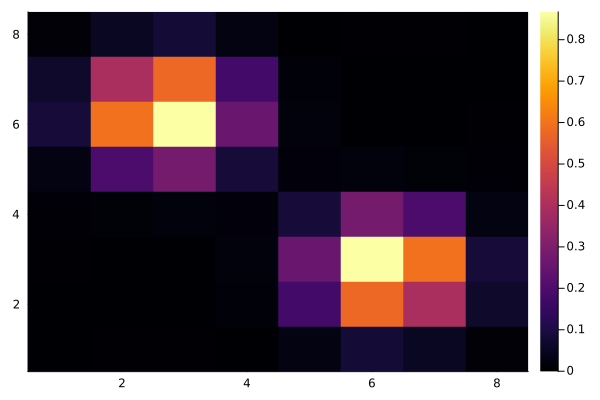

hi


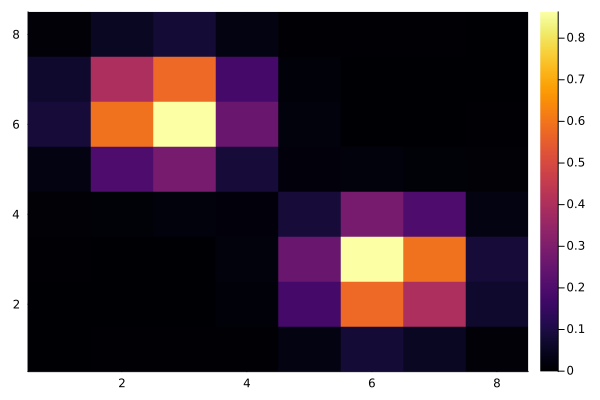

hi


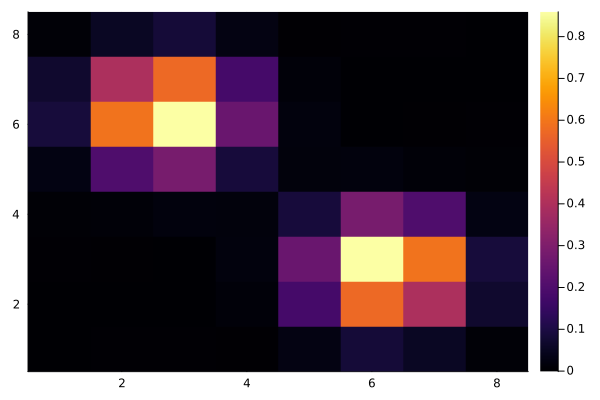

hi


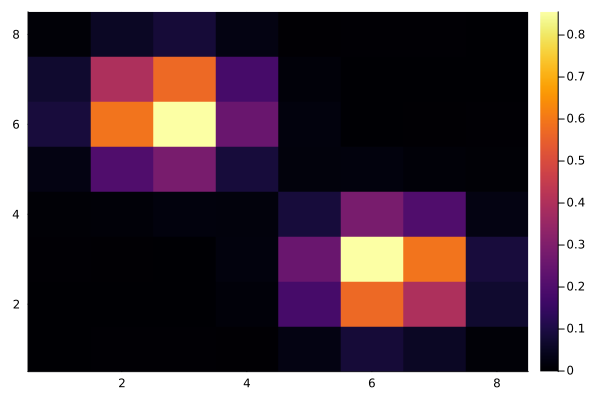

hi


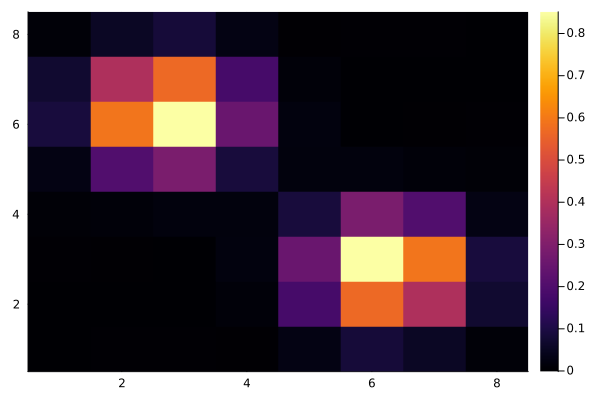

hi


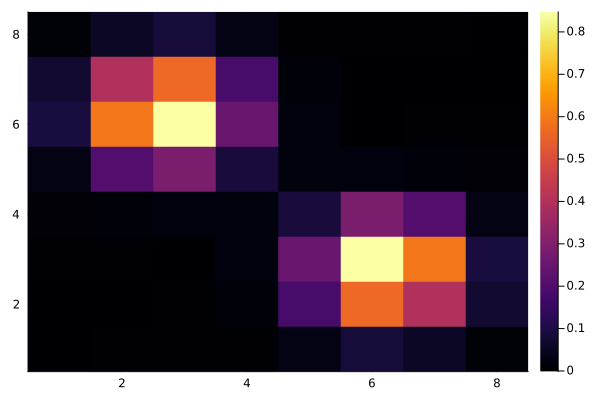

hi


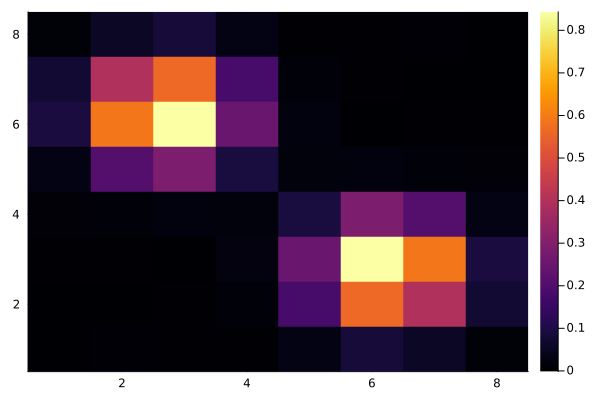

hi


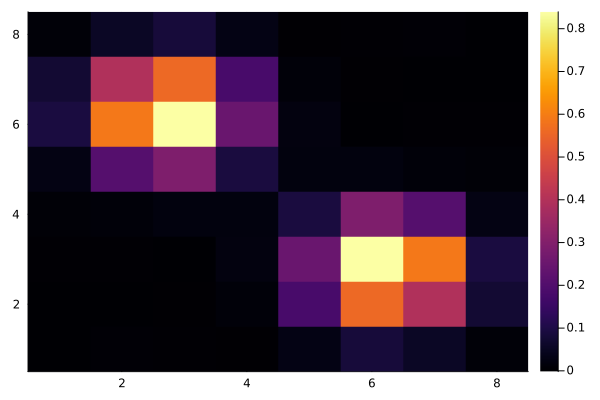

hi


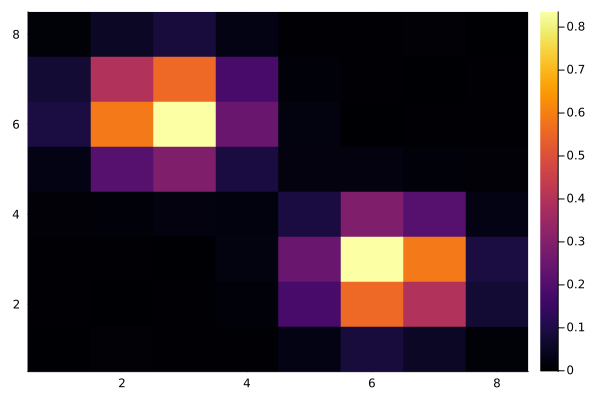

hi


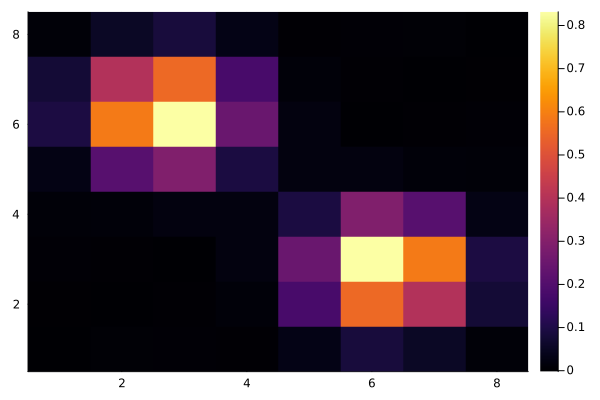

In [5]:

for i=1:max_iter
    if i%1000==0 
        println("hi")
        display(heatmap(real(transpose(irfft(copy(transpose(flow.wh)), flow.ny)))))
    end
    update(flow)
end


In [8]:
get_u(flow)

LoadError: AssertionError: sz[d1] == d >> 1 + 1

In [80]:
#print(size(flow.wh .* flow.k2I))
flow.k2I

8×5 Matrix{Float64}:
 0.0       1.0        0.25       0.111111   0.0625
 1.0       0.5        0.2        0.1        0.0588235
 0.25      0.2        0.125      0.0769231  0.05
 0.111111  0.1        0.0769231  0.0555556  0.04
 0.0625    0.0588235  0.05       0.04       0.03125
 0.111111  0.1        0.0769231  0.0555556  0.04
 0.25      0.2        0.125      0.0769231  0.05
 1.0       0.5        0.2        0.1        0.0588235

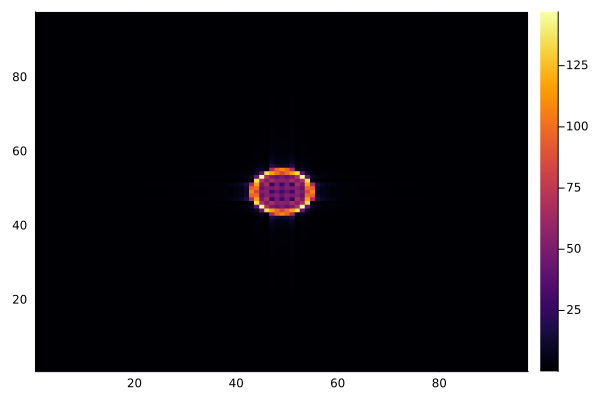

In [4]:
m = rand(10,10)
f = [(r = sqrt(x^2 + y^2); sinc(r)) for x in -6:0.125:6, y in -6:0.125:6]
mh = fft(f)
heatmap(abs.(fftshift(mh)))

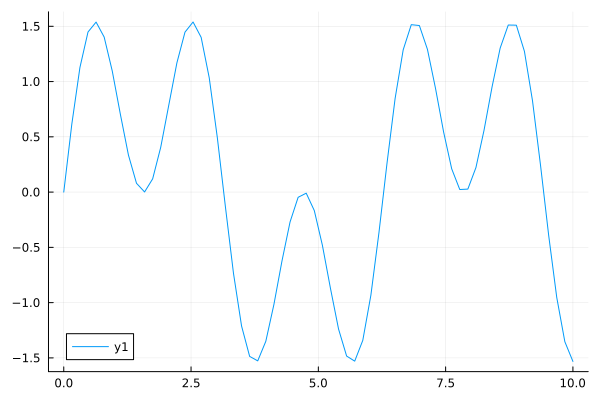

In [14]:
lin = range(0,10,64)
test = sin.(lin) + sin.(3*lin)
plot(lin, test)

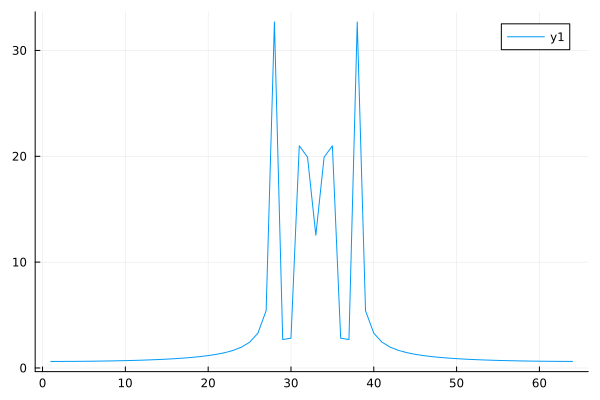

In [15]:
testh = fft(test)
plot(abs.(fftshift(testh)))

In [16]:
x,y = meshgrid(lin, 2 .*lin)
test = sin.(x) + sin.(3*y)

64×64 Matrix{Float64}:
  0.0         0.158064    0.312155    …  -0.254917   -0.404555   -0.544021
  0.814798    0.972863    1.12695         0.559881    0.410243    0.270777
  0.94475     1.10281     1.2569          0.689833    0.540195    0.400729
  0.280629    0.438694    0.592784        0.0257125  -0.123925   -0.263392
 -0.619363   -0.461299   -0.307208       -0.87428    -1.02392    -1.16338
 -0.998774   -0.84071    -0.68662     …  -1.25369    -1.40333    -1.5428
 -0.538705   -0.380641   -0.22655        -0.793622   -0.94326    -1.08273
  0.374151    0.532216    0.686306        0.119234   -0.0304035  -0.16987
  0.97253     1.13059     1.28468         0.717613    0.567975    0.428509
  0.753487    0.911551    1.06564         0.49857     0.348932    0.209466
 -0.0988698   0.0591947   0.213285    …  -0.353787   -0.503424   -0.642891
 -0.868125   -0.710061   -0.55597        -1.12304    -1.27268    -1.41215
 -0.907712   -0.749648   -0.595557       -1.16263    -1.31227    -1.45173
  ⋮      

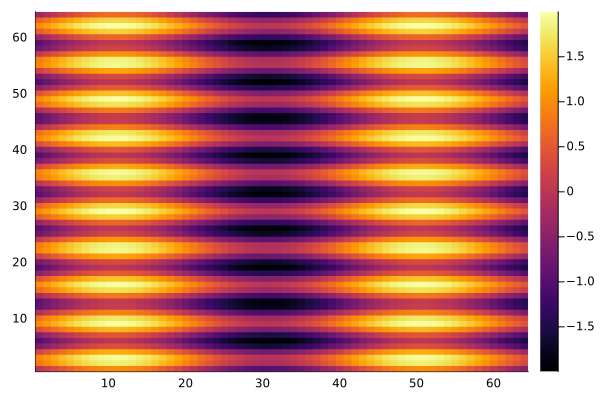

In [17]:
heatmap(test)

(33, 64)

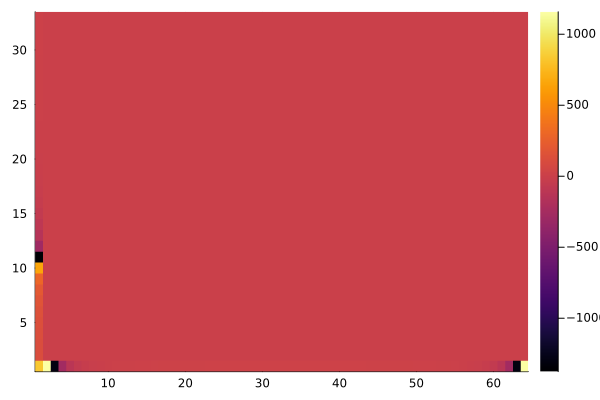

In [18]:
mh = rfft(test)
print(size(mh))
heatmap(real(mh))

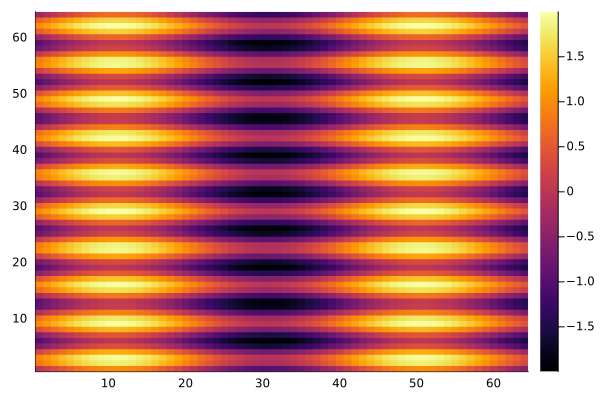

In [19]:
xn = irfft(mh, 64)
heatmap(xn)

In [64]:
a = range(0,10)
b = range(0,5)
x,y = meshgrid(a,b)

x .* y

6×11 Matrix{Float64}:
 0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0  10.0
 0.0  2.0   4.0   6.0   8.0  10.0  12.0  14.0  16.0  18.0  20.0
 0.0  3.0   6.0   9.0  12.0  15.0  18.0  21.0  24.0  27.0  30.0
 0.0  4.0   8.0  12.0  16.0  20.0  24.0  28.0  32.0  36.0  40.0
 0.0  5.0  10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0

In [1]:
using CUDA

In [26]:
a = cu(ones(10000,10000))
a[:,:]

10000×10000 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.

In [11]:
b = fft(a)

10000×10000 CuArray{ComplexF32, 2, CUDA.Mem.DeviceBuffer}:
 5.00029f7+0.0im      -2131.82+352.288im  …  -2131.82-352.287im
  -3926.49+616.779im  -2115.74+1572.02im       3891.1-375.871im
  -1022.84-560.474im  -2029.42-1870.58im      1429.53+317.535im
   205.328+4028.4im   -1022.31-2479.52im     -1091.83-2259.19im
  -1110.25+1748.27im   3556.03-3282.64im     -569.476+5111.52im
  -2717.88-2273.01im  -1586.98+973.248im  …   -1040.0+6669.48im
   514.594+1200.85im   -408.94-2005.37im     -1257.18+1178.05im
  -2220.48+5902.61im  -85.4241+2948.96im      260.753+1168.68im
   361.002-639.797im   2312.93+351.561im      840.913-253.385im
   1990.55+908.362im   900.535-3078.49im      1776.95-1906.14im
   -1356.6-4765.85im    3180.6-1127.86im  …  -962.256+1303.58im
   -719.34-1448.69im  -2776.07+2521.57im     -785.204-4076.99im
  -910.446-208.747im   -2122.8+2663.41im      3067.41+1438.53im
          ⋮                               ⋱  
  -910.445+208.746im   3067.41-1438.53im      -2122.8-2663.41im

In [11]:
mutable struct testscruct
    a
    b
    c
end

function testfun(self::testscruct)
    self.a = self.a .* self.b
end

test1 = testscruct(cu(rand(100,100)), cu(rand(100,100)), 1.0)
testfun(test1)

100×100 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.256886   0.301884    0.158832    …  0.0646296   0.00832214  0.0531157
 0.129149   0.899003    0.170262       0.383191    0.405234    0.479703
 0.036328   0.0254606   0.500369       0.565021    0.0192208   0.399387
 0.543418   0.409365    0.139725       0.160437    0.387284    0.0475385
 0.0710114  0.404167    0.225854       0.126353    0.490799    0.66524
 0.252598   0.125239    0.185004    …  0.00162649  0.141231    0.615112
 0.0654442  0.00189296  0.0494668      0.483084    0.0579812   0.0358114
 0.0485208  0.477955    0.00450105     0.0363502   0.262513    0.111068
 0.248737   0.519439    0.0736857      0.199519    0.224539    0.0183831
 0.422628   0.0127541   0.50352        0.210575    0.0212854   0.00166199
 0.889912   0.286493    0.819293    …  0.491704    0.0450234   0.507895
 0.463572   0.0576977   0.0232401      0.0183662   0.225387    0.355409
 0.171468   0.0920385   0.0157163      0.142541    0.200651    0.00749733
 ⋮   

LoadError: UndefVarError: teststruct not defined